# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

There were a total of 17 campaigns in this dataset.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [28]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, auc, average_precision_score, f1_score, make_scorer, precision_recall_curve, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression




In [29]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [30]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [32]:
print(df.describe(include='all'))  # Descriptive stats for all columns

                age     job  marital          education default housing  \
count   41188.00000   41188    41188              41188   41188   41188   
unique          NaN      12        4                  8       3       3   
top             NaN  admin.  married  university.degree      no     yes   
freq            NaN   10422    24928              12168   32588   21576   
mean       40.02406     NaN      NaN                NaN     NaN     NaN   
std        10.42125     NaN      NaN                NaN     NaN     NaN   
min        17.00000     NaN      NaN                NaN     NaN     NaN   
25%        32.00000     NaN      NaN                NaN     NaN     NaN   
50%        38.00000     NaN      NaN                NaN     NaN     NaN   
75%        47.00000     NaN      NaN                NaN     NaN     NaN   
max        98.00000     NaN      NaN                NaN     NaN     NaN   

         loan   contact  month day_of_week  ...      campaign         pdays  \
count   41188     41

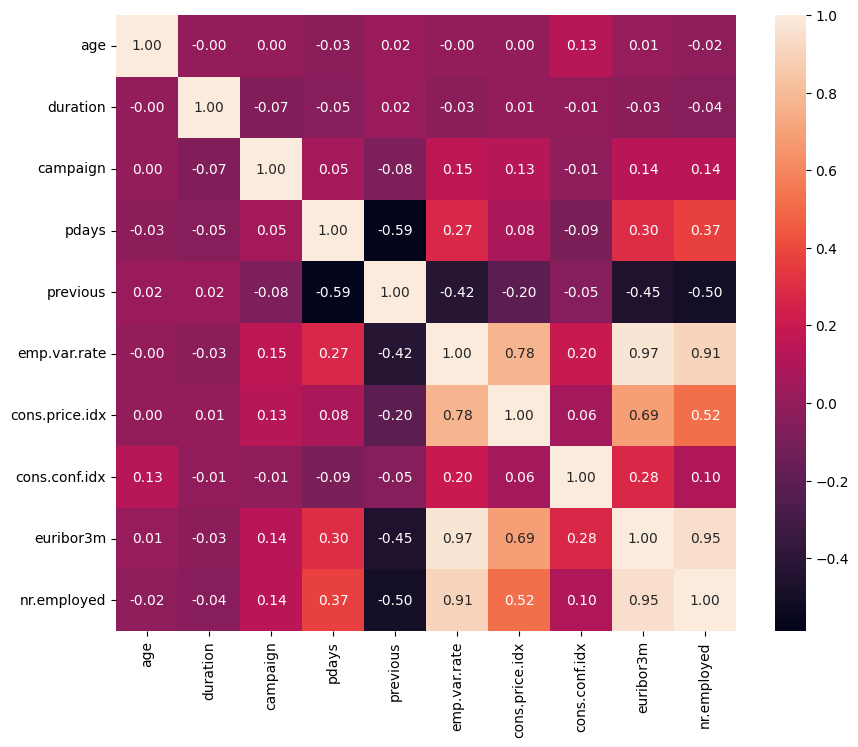

In [33]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

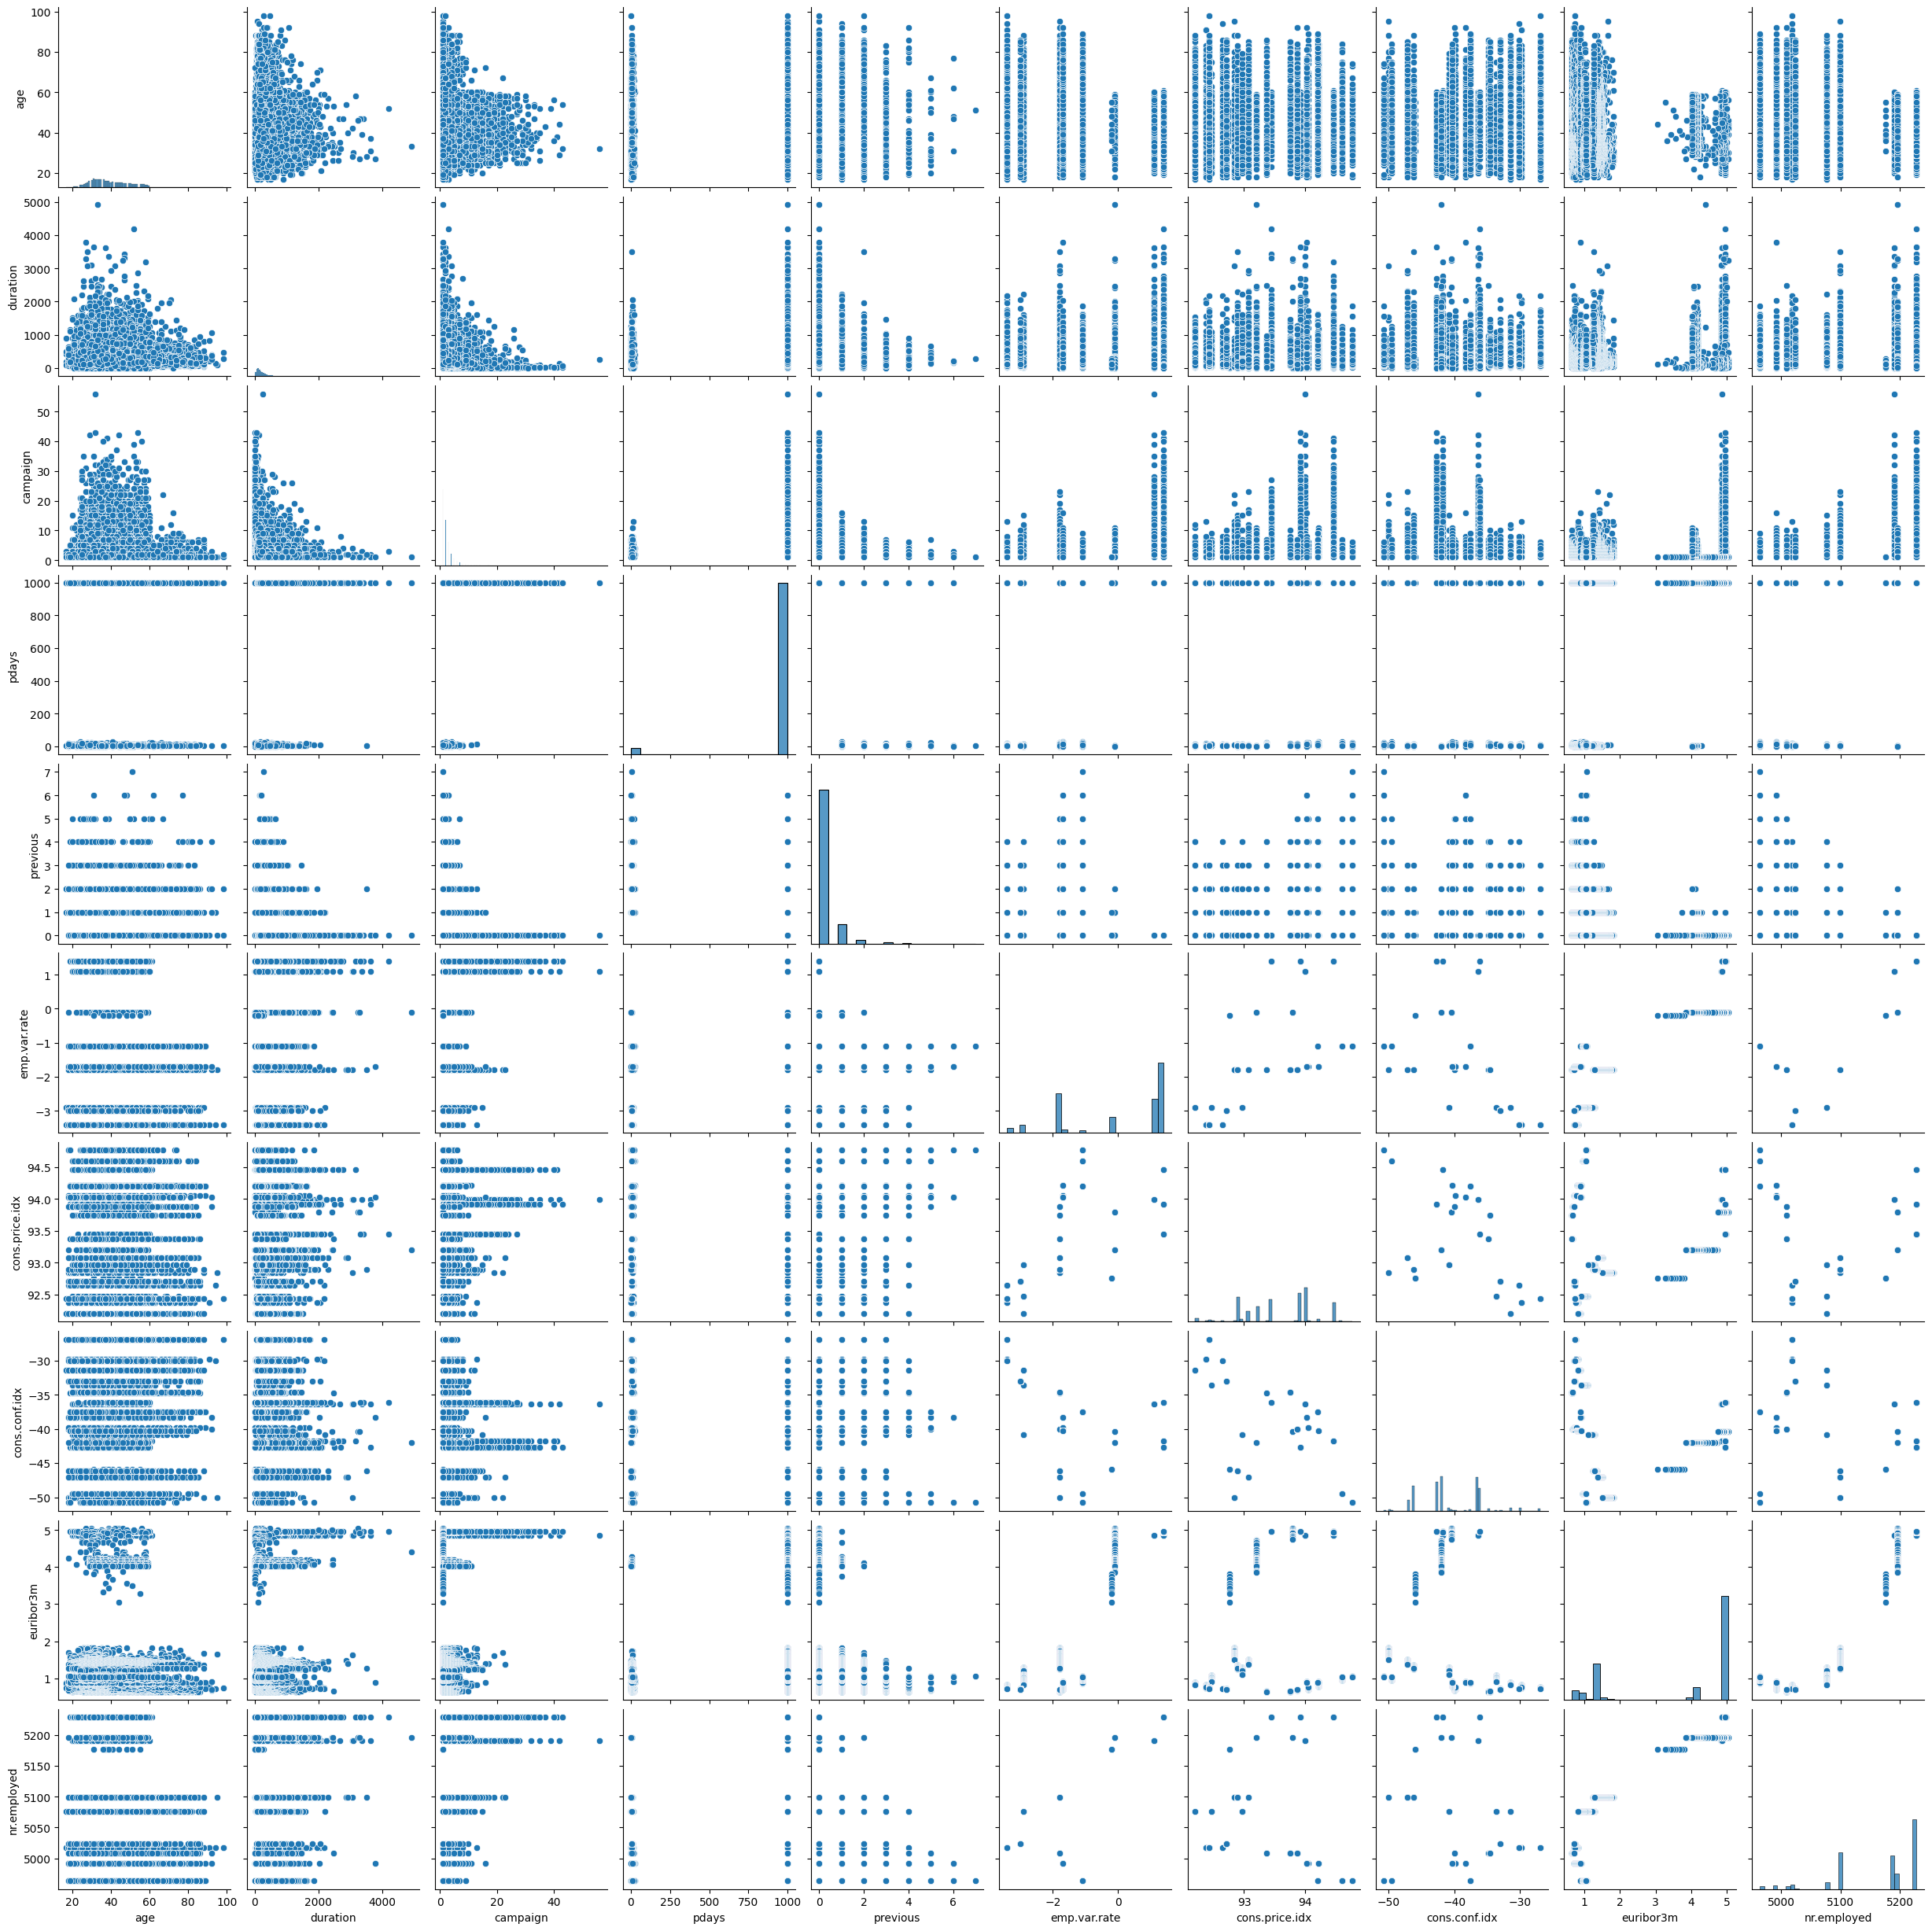

In [34]:
sns.pairplot(df)
plt.show()

In [35]:
missing_values = df.isnull()

# Count the number of missing values in each column
missing_columns = missing_values.sum()

print('Missing values in each column:')
print(missing_columns)

Missing values in each column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


There are no missing columns in the dataset. All missing columns were previously encoded as 'unkown'. For now, we will use 'unkown' as a class variable. We also have 10 categorical columns that need to be encoded. These columns are job, marital, education, default, housing, loan, contact, month, day_of_week and poutcome.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.


The business goal is to identify a model that can predict a contact's success in terms of client deposit subscription. Additionally, we aim to determine the most influential features for contact success. This will enable the business to prioritize these criteria, optimizing cost-efficiency and maximizing positive outcomes.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [36]:
selected_data = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'y']]


In [37]:
for column in selected_data.columns:
    unique_values = selected_data[column].unique()
    print(f"{column}: {len(unique_values)} unique values")
    print(unique_values)
    print()

age: 78 unique values
[56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]

job: 12 unique values
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

marital: 4 unique values
['married' 'single' 'divorced' 'unknown']

education: 8 unique values
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

default: 3 unique values
['no' 'unknown' 'yes']

housing: 3 unique values
['no' 'yes' 'unknown']

loan: 3 unique values
['no' 'yes' 'unknown']

y: 2 unique values
['no' 'yes']



In [38]:


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age']),
        ('ord', OrdinalEncoder(categories=[['unemployed', 'student', 'blue-collar','housemaid', 'services', 'retired', 'admin.', 'technician','self-employed', 'management', 'entrepreneur', 'unknown'],
                                         ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree', 'unknown']]), ['job', 'education']),
        ('cat', OneHotEncoder(), ['marital', 'default', 'housing', 'loan'])
    ])


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [39]:


X = selected_data.drop('y', axis=1)
y = selected_data['y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [40]:


X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_preprocessed = preprocessor.transform(X_test)

# Create a baseline model
baseline_model = DummyClassifier(strategy='most_frequent')

# Fit the baseline model
baseline_model.fit(X_train_preprocessed, y_train)

# Make predictions using the baseline model
y_pred = baseline_model.predict(X_test_preprocessed)

# Calculate the accuracy of the baseline model
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline model accuracy: {accuracy:.2f}")

Baseline model accuracy: 0.89


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [41]:
# Create a logistic regression model


logreg_model = LogisticRegression(max_iter=1000)

# Fit the logistic regression model
logreg_model.fit(X_train_preprocessed, y_train)

# Make predictions using the logistic regression model
y_pred = logreg_model.predict(X_test_preprocessed)

# Calculate the accuracy of the logistic regression model
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression model accuracy: {accuracy:.2f}")

Logistic Regression model accuracy: 0.89


### Problem 9: Score the Model

What is the accuracy of your model?

Accuracy is 0.89

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [42]:
# Define a list of models to train


models = [
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('SVM', SVC(random_state=42))
]

# Initialize an empty list to store the results
results = []

# Train each model and store the training time, training accuracy, and test accuracy
for name, model in models:
    start_time = time.time()
    model.fit(X_train_preprocessed, y_train)
    train_time = time.time() - start_time
    
    train_accuracy = accuracy_score(y_train, model.predict(X_train_preprocessed))
    test_accuracy = accuracy_score(y_test, model.predict(X_test_preprocessed))
    
    results.append([name, train_time, train_accuracy, test_accuracy])
    
    # Print the parameters chosen for each model
    print(f"{name} parameters: {model.get_params()}")
    
# Create a DataFrame to display the results
results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])
print(results_df)

KNN parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Decision Tree parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
SVM parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
           Model  Train Time  Train Accuracy  Test Accuracy
0            KNN    0.021341        0.889833       0.872420
1  Decision Tree    0.072252        0.916601       0.862224
2            SVM    7.222501        0.887557       0.88650

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [43]:


# Create a smaller dataset using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.90, random_state=42)
for train_index, _ in split.split(X_train_preprocessed, y_train):
    X_train_small = X_train_preprocessed[train_index]
    y_train_small = y_train.iloc[train_index]



print(f"X_train_small size: {X_train_small.shape}")
print(f"y_train_small size: {y_train_small.shape}")

print(f"X_train_preprocessed size: {X_train_preprocessed.shape}")
print(f"X_train size: {X_train.shape}")
print(f"y_train size: {y_train.shape}")

X_train_small size: (3295, 16)
y_train_small size: (3295,)
X_train_preprocessed size: (32950, 16)
X_train size: (32950, 7)
y_train size: (32950,)


In [44]:
models = [
    ('KNN', KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }),
    ('Decision Tree', DecisionTreeClassifier(random_state=42), {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 5]
    }),
    ('SVM', SVC(random_state=42), {
        'kernel': [ 'linear'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1, 1],
        'probability': [True]
    })
]

In [45]:

def get_feature_names(column_transformer):
    feature_names = []
    
    for transformer_in_columns in column_transformer.transformers_:
        transformer_name = transformer_in_columns[0]
        transformer = transformer_in_columns[1]
        columns = transformer_in_columns[2]
        
        if isinstance(transformer, Pipeline): 
            transformer = transformer.steps[-1][1]
        
        if transformer_name == 'num' or transformer_name == 'ord':
            feature_names.extend(columns)
        
        elif transformer_name == 'cat':
            if isinstance(transformer, OneHotEncoder):
                transformed_features = transformer.get_feature_names_out(columns)
                feature_names.extend(transformed_features)
    return feature_names

In [46]:

def plot_roc_curve(y_test, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [47]:


def plot_precision_recall_curve(y_test, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    average_precision = average_precision_score(y_test, y_scores)
    
    plt.figure()
    plt.plot(recall, precision, label=f'Average Precision = {average_precision:0.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve for {model_name}')
    plt.legend(loc="lower left")
    plt.show()

def plot_feature_importance(name, feature_importances):
    plt.figure()
    plt.title(f'Top 10 feature importances for {name}')
    features, importances = zip(*feature_importances[:10])
    plt.barh(features, importances, align='center')
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()
    plt.show()

In [48]:


def grid_search_fit(name, model, param_grid, X_train, y_train, scoring):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, refit='f1', n_jobs=-1, return_train_score=True)
    grid_search.fit(X_train, y_train)
    return grid_search


def print_best_params_scores(name, grid_search):
    print(f"Grid search for {name} done")
    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Best f1 score: {grid_search.best_score_:.4f}")
    cv_results = grid_search.cv_results_
    print(f"  Best train accuracy: {cv_results['mean_train_accuracy'][grid_search.best_index_]:.4f}")
    print(f"  Best test accuracy: {cv_results['mean_test_accuracy'][grid_search.best_index_]:.4f}")
    

def get_feature_importance(name, best_estimator, feature_names):
    if name == "SVM":
        if best_estimator.kernel == "linear":
            importance = best_estimator.coef_[0]
        else:
            print("The best SVM model is not linear, so individual feature importances are not available.")
            importance = []
    elif name == "Decision Tree":
        importance = best_estimator.feature_importances_
    
    feature_importances = sorted(list(zip(feature_names, importance)), key=lambda x: x[1], reverse=True)
    return feature_importances


def print_top_features(name, feature_importances):
    print(f"  Top 10 features for {name} by importance:")
    for feature, importance in feature_importances[:10]:
        print(f"    {feature}: {importance}")


def perform_grid_search(models, X_train_small, y_train_small, X_train_preprocessed, y_train, X_test_preprocessed, y_test, feature_names):
    best_models = []
    model_runtimes = []
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, pos_label='yes')
    }

    for name, model, param_grid in models:
        start_time = time.time()

        if name == 'SVM':
            grid_search = grid_search_fit(name, model, param_grid, X_train_small, y_train_small, scoring)
        else:
            grid_search = grid_search_fit(name, model, param_grid, X_train_preprocessed, y_train, scoring)
        
        end_time = time.time()
        runtime = end_time - start_time
        model_runtimes.append((name, runtime))

        print_best_params_scores(name, grid_search)

        best_estimator = grid_search.best_estimator_
        if name in ["SVM", "Decision Tree"]:
            feature_importances = get_feature_importance(name, best_estimator, feature_names)
            print_top_features(name, feature_importances)
            best_models.append((name, best_estimator, grid_search.best_params_, grid_search.cv_results_, feature_importances))
        else:
            best_models.append((name, best_estimator, grid_search.best_params_, grid_search.cv_results_))
        
        # Calculate the model scores on the test set
        y_scores = best_estimator.predict_proba(X_test_preprocessed)[:, 1]
        
        # Call the plot_roc_curve function
        y_test_bin = np.where(y_test=='yes', 1, 0)
        plot_roc_curve(y_test_bin, y_scores, name)

        # Call the plot_precision_recall_curve function
        plot_precision_recall_curve(y_test_bin, y_scores, name)

        # Plot confusion matrix
        ConfusionMatrixDisplay.from_estimator(best_estimator, X_test_preprocessed, y_test)
        plt.title(f'Confusion Matrix for {name}')
        plt.show()

        # If feature importance is calculated, plot feature importance
        if 'feature_importances' in locals():
            plot_feature_importance(name, feature_importances)
    
    return best_models, model_runtimes




Grid search for KNN done
  Best parameters: {'n_neighbors': 3, 'weights': 'distance'}
  Best f1 score: 0.1542
  Best train accuracy: 0.9097
  Best test accuracy: 0.8522


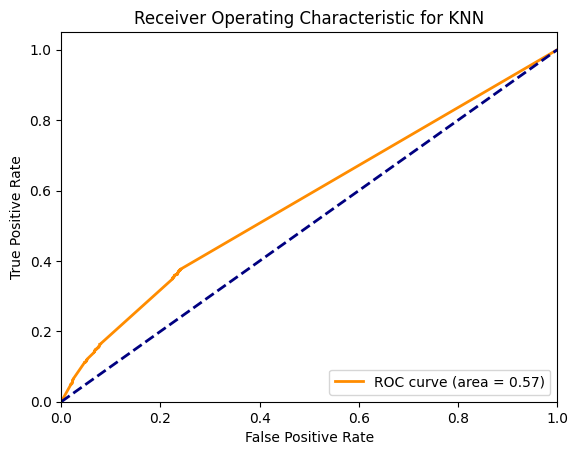

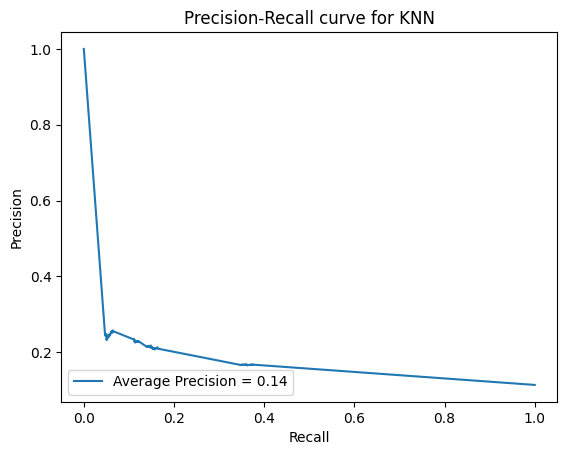

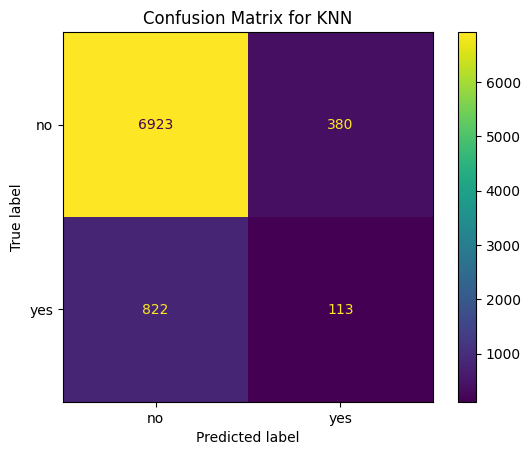

Grid search for Decision Tree done
  Best parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1}
  Best f1 score: 0.1402
  Best train accuracy: 0.9163
  Best test accuracy: 0.8656
  Top 10 features for Decision Tree by importance:
    age: 0.3660013707554424
    job: 0.19010003283392005
    education: 0.1375453029192563
    housing_no: 0.0501605694285253
    housing_yes: 0.0447807402738067
    loan_yes: 0.03517409230728364
    marital_married: 0.03475951938043857
    marital_single: 0.033129154785295746
    marital_divorced: 0.031327606083744484
    loan_no: 0.03014562803715663


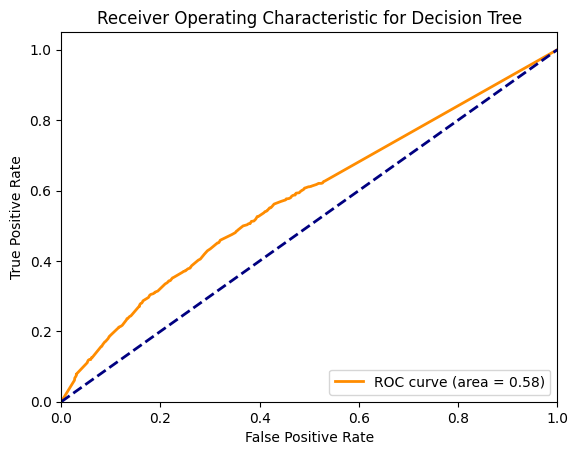

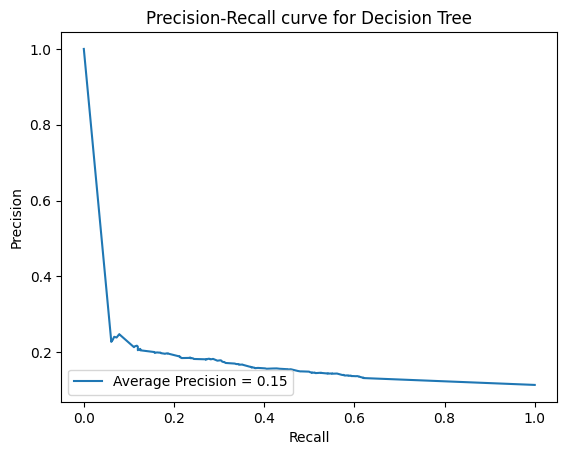

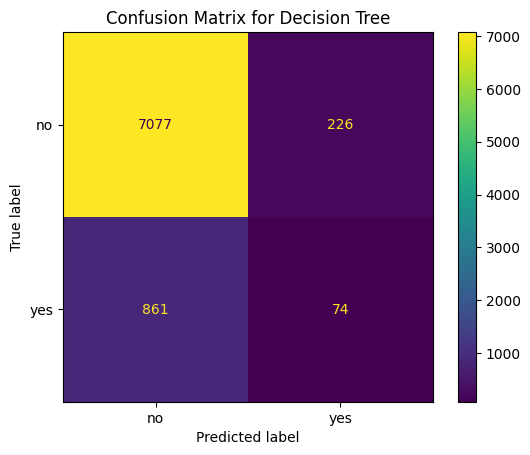

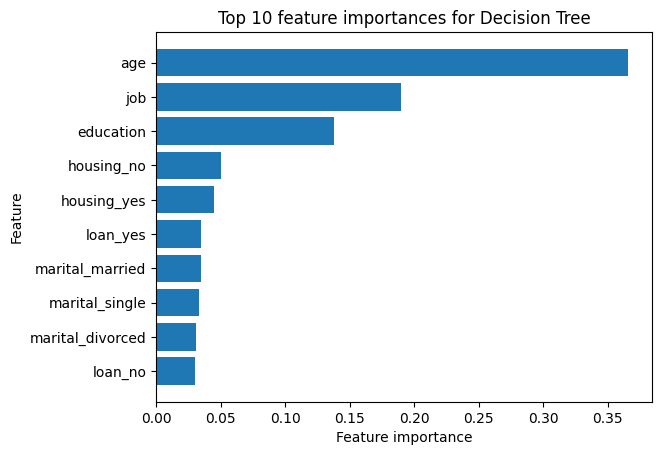

Grid search for SVM done
  Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'probability': True}
  Best f1 score: 0.0000
  Best train accuracy: 0.8874
  Best test accuracy: 0.8874
  Top 10 features for SVM by importance:
    default_no: 0.0001148557973291442
    housing_yes: 9.56348937013185e-05
    age: 9.372477323424815e-05
    marital_single: 9.068895796746079e-05
    loan_no: 5.258992891407632e-05
    marital_unknown: 0.0
    default_yes: 0.0
    loan_yes: -1.4111043552811342e-06
    job: -1.7127312528120164e-05
    marital_married: -1.8676959244207092e-05


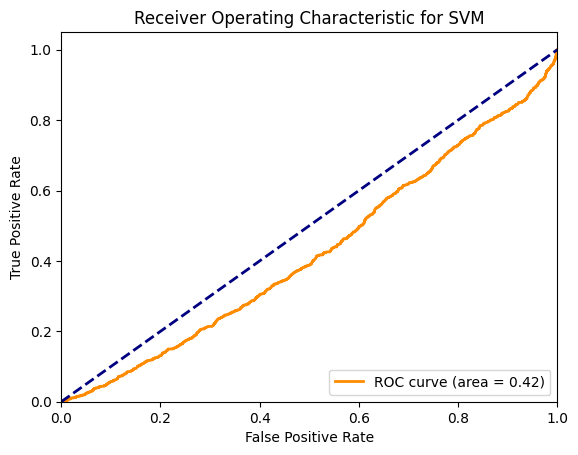

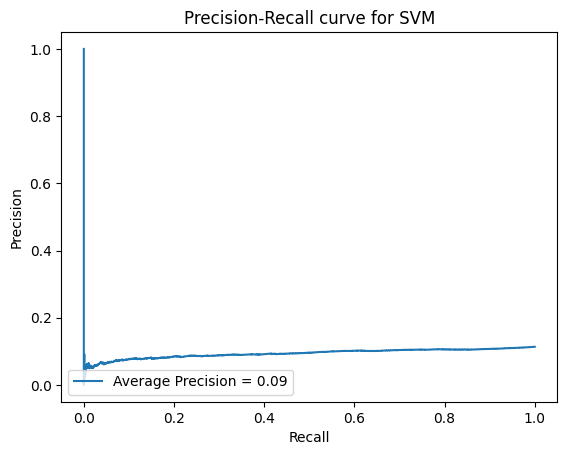

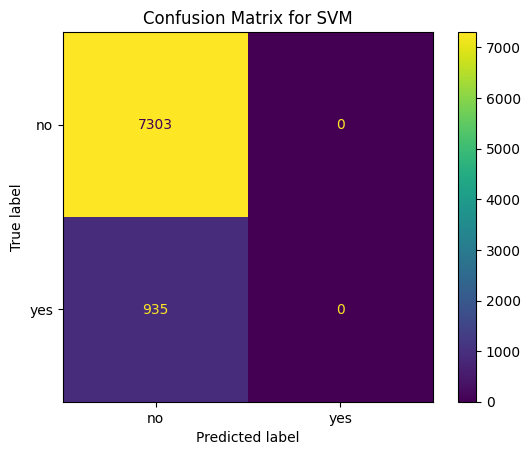

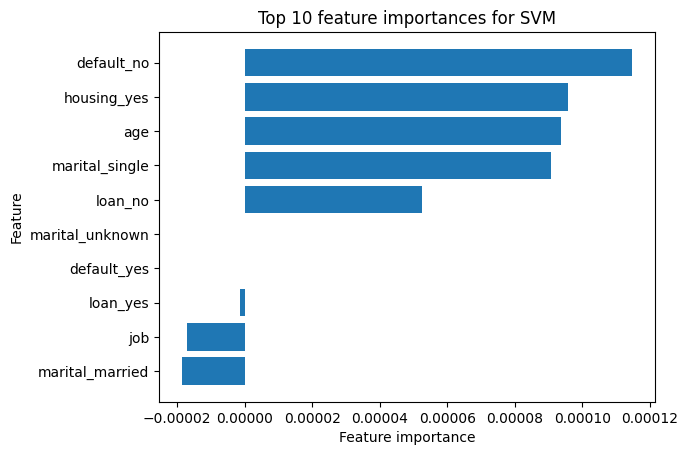

Model: KNN
Best Estimator: KNeighborsClassifier(n_neighbors=3, weights='distance')
Best Parameters: {'n_neighbors': 3, 'weights': 'distance'}
CV Results: {'mean_fit_time': array([0.0322156 , 0.03821445, 0.02340746, 0.02380438, 0.01860523,
       0.02118206, 0.01964254, 0.02444639]), 'std_fit_time': array([0.00990896, 0.01353424, 0.00359694, 0.00394825, 0.00047321,
       0.00250361, 0.0021122 , 0.00704887]), 'mean_score_time': array([0.69464579, 0.62450137, 0.64859481, 0.59469724, 0.63195429,
       0.60162535, 0.71273651, 0.64399738]), 'std_score_time': array([0.02813247, 0.00745636, 0.00953172, 0.01572789, 0.04828249,
       0.02302468, 0.01475238, 0.01547656]), 'param_n_neighbors': masked_array(data=[3, 3, 5, 5, 7, 7, 9, 9],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                   'uniform', 'distance', 'uniform', '

In [49]:
best_models, model_runtimes = perform_grid_search(models, X_train_small, y_train_small, X_train_preprocessed, y_train, X_test_preprocessed, y_test, get_feature_names(preprocessor))

for model in best_models:
    print(f"Model: {model[0]}")
    print(f"Best Estimator: {model[1]}")
    print(f"Best Parameters: {model[2]}")
    print(f"CV Results: {model[3]}")
    if len(model) > 4:
        print(f"Feature Importances: {model[4]}")
    print("\n")

# print model runtimes
for runtime in model_runtimes:
    print(f"Model: {runtime[0]}")
    print(f"Runtime: {runtime[1]} seconds")
    print("\n")

It appears that the training accuracy is high but the test accuracy is lower than the training accuracy. This might indicate an overfitting of data. We will try to include all the features available to us and run the models again.

In [50]:
X = df.drop(['y','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'], axis=1)
y = df['y']

# Train-test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          41188 non-null  int64 
 1   job          41188 non-null  object
 2   marital      41188 non-null  object
 3   education    41188 non-null  object
 4   default      41188 non-null  object
 5   housing      41188 non-null  object
 6   loan         41188 non-null  object
 7   contact      41188 non-null  object
 8   month        41188 non-null  object
 9   day_of_week  41188 non-null  object
 10  duration     41188 non-null  int64 
 11  campaign     41188 non-null  int64 
 12  pdays        41188 non-null  int64 
 13  previous     41188 non-null  int64 
 14  poutcome     41188 non-null  object
dtypes: int64(5), object(10)
memory usage: 4.7+ MB


In [52]:
expanded_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age','duration','campaign','pdays','previous']),
        ('ord', OrdinalEncoder(categories=[['unemployed', 'student', 'blue-collar','housemaid', 'services', 'retired', 'admin.', 'technician','self-employed', 'management', 'entrepreneur', 'unknown'],
                                         ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree', 'unknown'],['failure','nonexistent', 'success']]), ['job', 'education','poutcome']),
        ('cat', OneHotEncoder(), ['marital', 'default', 'housing', 'loan','month','day_of_week','contact'])
    ])


In [53]:


X_train_preprocessed_2 = expanded_preprocessor.fit_transform(X_train_2)

# Transform the test data
X_test_preprocessed_2 = expanded_preprocessor.transform(X_test_2)

# Create a smaller dataset using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.90, random_state=42)
for train_index, _ in split.split(X_train_preprocessed_2, y_train_2):
    X_train_small_2 = X_train_preprocessed_2[train_index]
    y_train_small_2 = y_train_2.iloc[train_index]


print(f"X_train_small size: {X_train_small_2.shape}")
print(f"y_train_small size: {y_train_small_2.shape}")
print(f"X_train_preprocessed size: {X_train_preprocessed_2.shape}")

print(f"X_train size: {X_train_2.shape}")
print(f"y_train size: {y_train_2.shape}")

X_train_small size: (3295, 38)
y_train_small size: (3295,)
X_train_preprocessed size: (32950, 38)
X_train size: (32950, 15)
y_train size: (32950,)


Grid search for KNN done
  Best parameters: {'n_neighbors': 5, 'weights': 'distance'}
  Best f1 score: 0.4327
  Best train accuracy: 1.0000
  Best test accuracy: 0.8982


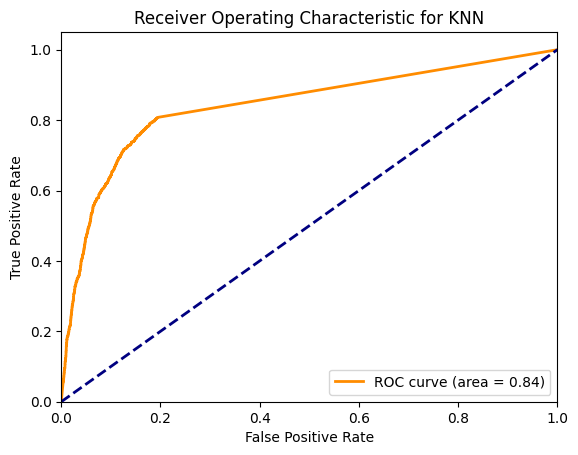

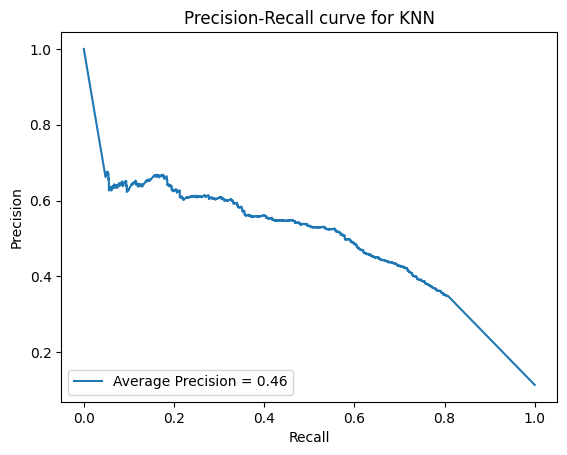

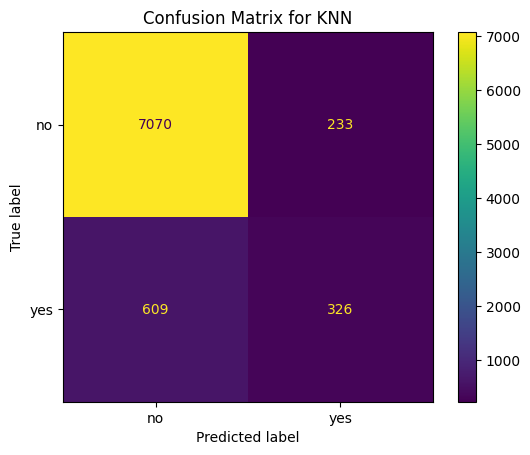

Grid search for Decision Tree done
  Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1}
  Best f1 score: 0.5112
  Best train accuracy: 0.9319
  Best test accuracy: 0.9038
  Top 10 features for Decision Tree by importance:
    duration: 0.4469679864601734
    pdays: 0.23016583059787077
    age: 0.06205527717266181
    month_mar: 0.035620884003431615
    month_oct: 0.030731128218811396
    month_jun: 0.01949971469483294
    campaign: 0.01900958911992089
    job: 0.018427501576849765
    month_sep: 0.016861933514489977
    education: 0.016137756173116306


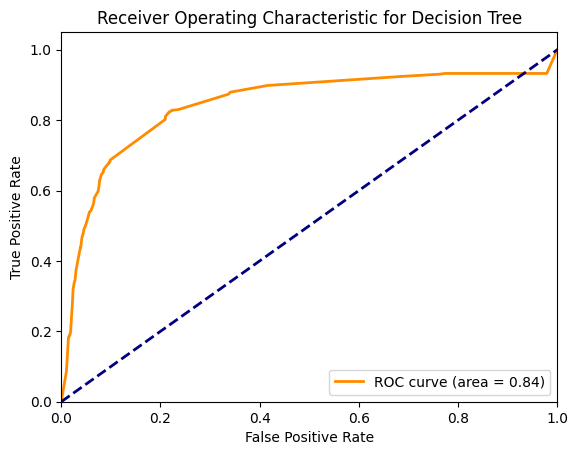

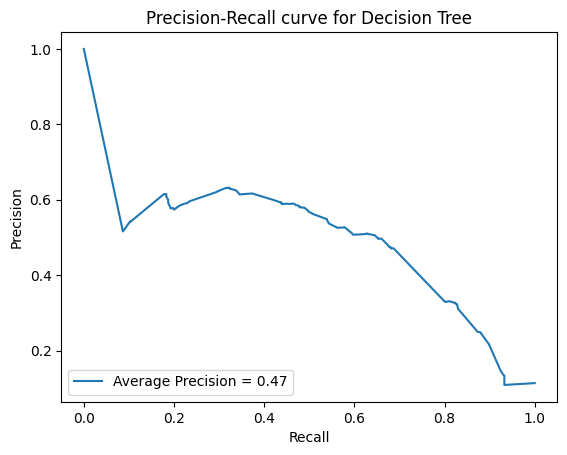

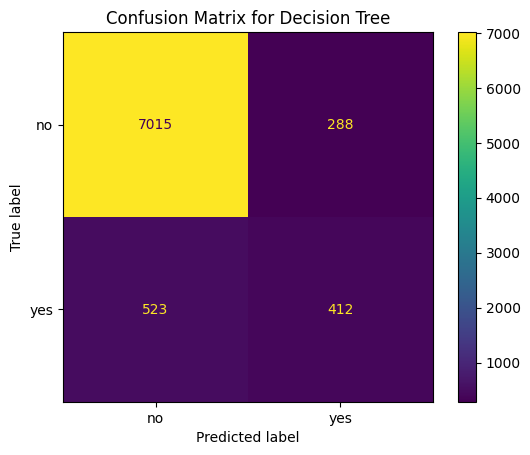

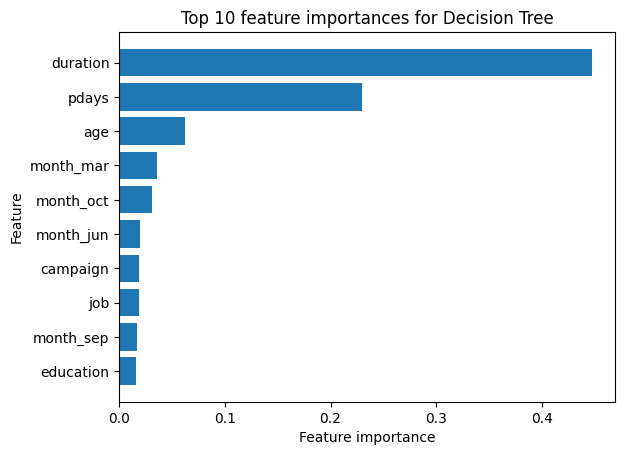

Grid search for SVM done
  Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear', 'probability': True}
  Best f1 score: 0.3833
  Best train accuracy: 0.9036
  Best test accuracy: 0.9002
  Top 10 features for SVM by importance:
    duration: 0.3664750851648404
    month_mar: 0.26948534426723114
    contact_cellular: 0.19295671689970817
    month_sep: 0.19219616286093189
    month_oct: 0.1548628827519849
    month_jun: 0.11586076919824251
    default_no: 0.09875991028783204
    day_of_week_thu: 0.07272268446106267
    month_apr: 0.06827598029485671
    poutcome: 0.06276690155648623


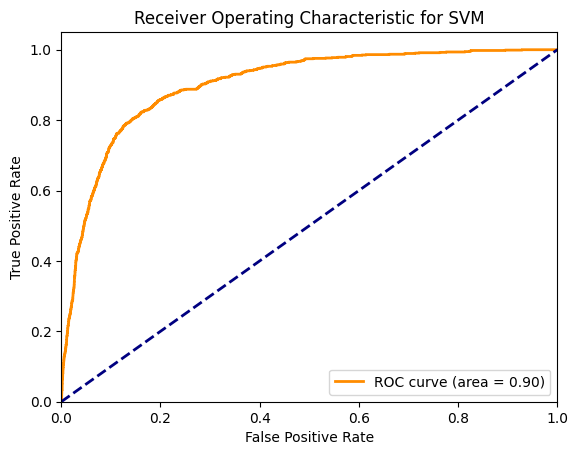

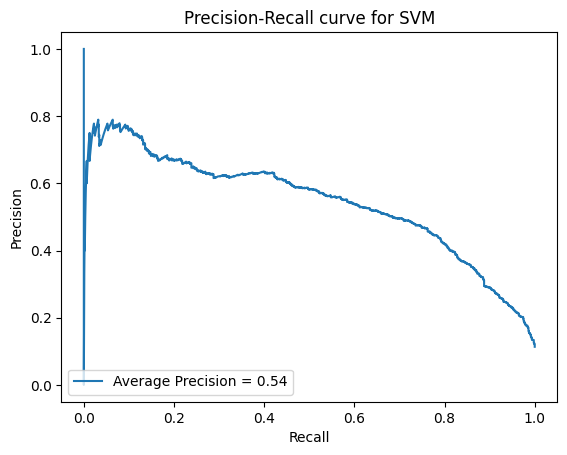

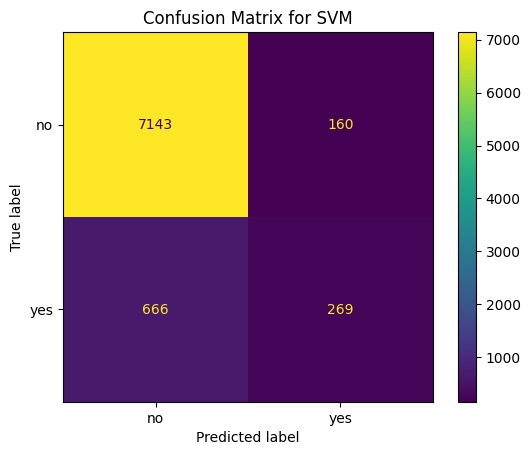

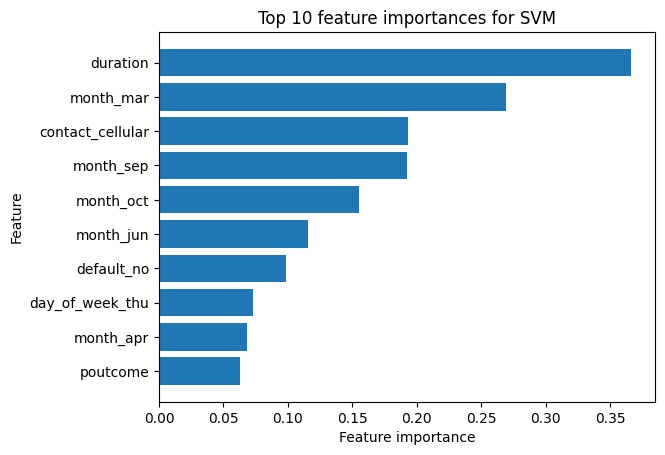

Model: KNN
Best Estimator: KNeighborsClassifier(weights='distance')
Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}
CV Results: {'mean_fit_time': array([0.02028666, 0.02163501, 0.02423348, 0.03631711, 0.02508578,
       0.02402763, 0.02158914, 0.02304225]), 'std_fit_time': array([0.00072594, 0.0017873 , 0.00208546, 0.00873421, 0.00258815,
       0.00101439, 0.00164719, 0.00359394]), 'mean_score_time': array([0.8171701 , 0.76087656, 0.96018796, 0.85124831, 0.82696729,
       0.77589078, 0.80678778, 0.73425541]), 'std_score_time': array([0.03170634, 0.01916384, 0.02160892, 0.02216196, 0.01632267,
       0.02132333, 0.03612508, 0.03554359]), 'param_n_neighbors': masked_array(data=[3, 3, 5, 5, 7, 7, 9, 9],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                   'uniform', 'distance', 'uniform', 'distance'],
   

In [54]:
best_models, model_runtimes = perform_grid_search(models, X_train_small_2, y_train_small_2, X_train_preprocessed_2, y_train_2, X_test_preprocessed_2, y_test_2, get_feature_names(expanded_preprocessor))

for model in best_models:
    print(f"Model: {model[0]}")
    print(f"Best Estimator: {model[1]}")
    print(f"Best Parameters: {model[2]}")
    print(f"CV Results: {model[3]}")
    if len(model) > 4:
        print(f"Feature Importances: {model[4]}")
    print("\n")

# print model runtimes
for runtime in model_runtimes:
    print(f"Model: {runtime[0]}")
    print(f"Runtime: {runtime[1]} seconds")
    print("\n")

##### Questions